# MNIST CNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import random

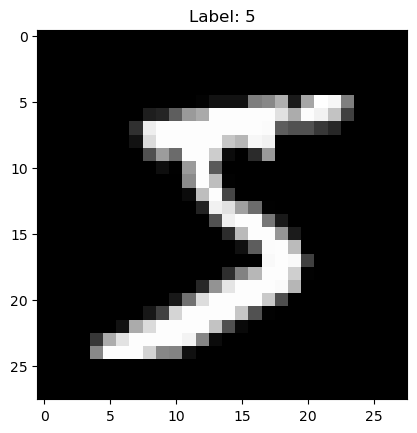

In [2]:
train = pd.read_csv('mnist_train.csv')
plt.imshow(train.iloc[0,1:].values.reshape(28,28), cmap='gray')
plt.title(f"Label: {train.iloc[0,0]}")
plt.show()

In [3]:
X = train.drop('label', axis=1).values.astype(np.float32) / 255.0
X = X.reshape(-1, 1, 28, 28)
y = train['label'].values.astype(np.int64)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_t = torch.tensor(X_train)
X_val_t = torch.tensor(X_val)
y_train_t = torch.tensor(y_train)
y_val_t = torch.tensor(y_val)
train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=128)

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(), nn.Linear(64*5*5, 128), nn.ReLU(), nn.Dropout(0.4), nn.Linear(128, 10)
        )
    def forward(self, x):
        x = self.cnn(x); x = self.fc(x); return x
model = CNN(); criterion = nn.CrossEntropyLoss(); optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
epochs = 10
train_acc_list = []
val_acc_list = []
for epoch in range(epochs):
    model.train(); correct=0; total=0
    for Xb, yb in train_dl:
        optimizer.zero_grad(); preds = model(Xb)
        loss = criterion(preds, yb); loss.backward(); optimizer.step()
        _, predicted = torch.max(preds, 1)
        correct += (predicted == yb).sum().item(); total += yb.size(0)
    train_acc = correct / total
    model.eval(); correct=0; total=0
    with torch.no_grad():
        for Xb, yb in val_dl:
            preds = model(Xb)
            _, predicted = torch.max(preds, 1)
            correct += (predicted == yb).sum().item(); total += yb.size(0)
    val_acc = correct / total
    train_acc_list.append(train_acc); val_acc_list.append(val_acc)
    print(f'Epoch {epoch+1}: Train Acc={train_acc:.4f} | Val Acc={val_acc:.4f}')

Epoch 1: Train Acc=0.8908 | Val Acc=0.9759
Epoch 2: Train Acc=0.9699 | Val Acc=0.9825
Epoch 3: Train Acc=0.9781 | Val Acc=0.9868
Epoch 4: Train Acc=0.9826 | Val Acc=0.9883
Epoch 5: Train Acc=0.9850 | Val Acc=0.9892
Epoch 6: Train Acc=0.9877 | Val Acc=0.9875
Epoch 7: Train Acc=0.9890 | Val Acc=0.9893
Epoch 8: Train Acc=0.9901 | Val Acc=0.9915
Epoch 9: Train Acc=0.9912 | Val Acc=0.9901
Epoch 10: Train Acc=0.9913 | Val Acc=0.9911


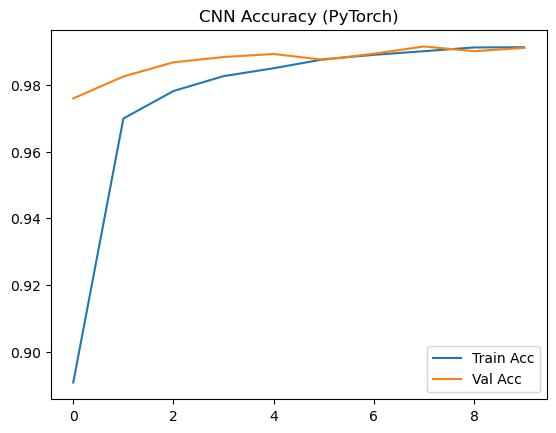

In [6]:
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.legend(); plt.title('CNN Accuracy (PyTorch)')
plt.show()

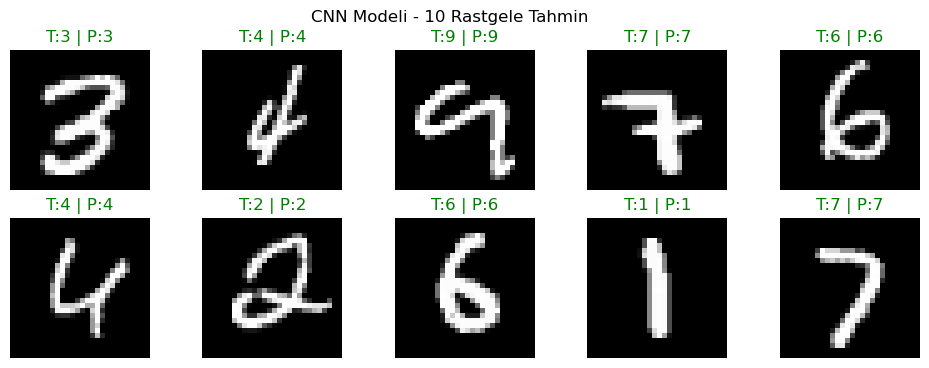

In [10]:
model.eval(); plt.figure(figsize=(12,4))
for i in range(10):
    idx = random.randint(0, len(X_val_t)-1)
    img = X_val_t[idx]; true_label = y_val_t[idx].item()
    with torch.no_grad():
        out = model(img.unsqueeze(0)); pred = torch.argmax(out, dim=1).item()
    plt.subplot(2,5,i+1)
    plt.imshow(img.squeeze().reshape(28,28), cmap='gray')
    plt.title(f'T:{true_label} | P:{pred}', color='green' if pred==true_label else 'red')
    plt.axis('off')
plt.suptitle('CNN Modeli - 10 Rastgele Tahmin')
plt.show()